## Analysis of high- and low-variance PCs in velocity space during rotation (panel B)

In [82]:
from definitions import ROOT_DIR
import os
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from functions_notebook import make_parallel_envs,set_config,cross_project_kin,plot_cross_projection,mean_ratio
import pickle
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import train_test_split
from stable_baselines3.common.vec_env import VecNormalize
from sb3_contrib import RecurrentPPO
from envs.environment_factory import EnvironmentFactory

### A. Low-variance PCs : linear classification performance

1. __Go to 2. to directly load the previously-obtained data__\
a. Define the 3 tasks : hold, cw, ccw\
b. Generate and label the velocities for each task\
c. Save the data

In [ ]:
num_ep = 50
num_cond = 3

PATH_TO_NORMALIZED_ENV = os.path.join(
    ROOT_DIR,
    "trained_models/curriculum_steps_complete_baoding_winner/32_phase_2_smaller_rate_resume/env.pkl",
)
PATH_TO_PRETRAINED_NET = os.path.join(
    ROOT_DIR,
    "trained_models/curriculum_steps_complete_baoding_winner/32_phase_2_smaller_rate_resume/model.zip",
)

env_name = "CustomMyoBaodingBallsP2"
render = False

C_hold = set_config(period=1e100,rot_dir=None)
C_cw = set_config(period=5,rot_dir="cw")
C_ccw = set_config(period=5,rot_dir="ccw")

configs = {'hold':C_hold,'cw':C_cw,'ccw':C_ccw}

conds = []

for task in configs :
    envs = make_parallel_envs(env_name, configs[task], num_env=1)
    envs = VecNormalize.load(PATH_TO_NORMALIZED_ENV, envs)
    envs.training = False
    envs.norm_reward = False
    custom_objects = {
        "learning_rate": lambda _: 0,
        "lr_schedule": lambda _: 0,
        "clip_range": lambda _: 0,
    }
    model = RecurrentPPO.load(
            PATH_TO_PRETRAINED_NET, env=envs, device="cpu", custom_objects=custom_objects
        )

    eval_model = model
    eval_env = EnvironmentFactory.create(env_name,**configs[task])
    tot_vel = []
    for n in range(num_ep):
        obs_tot = []
        cum_reward = 0
        lstm_states = None
        obs = eval_env.reset()
        episode_starts = np.ones((1,), dtype=bool)
        done = False
        timestep = 0
        while not done: 
            if render :
                eval_env.sim.render(mode="window")
                
            timestep += 1
            action, lstm_states = eval_model.predict(envs.normalize_obs(obs),
                                                    state=lstm_states,
                                                    episode_start=episode_starts,
                                                    deterministic=True,
                                                    )
                                                        
            obs, rewards, done, info = eval_env.step(action)
            episode_starts = done
            cum_reward += rewards
            obs_tot.append(obs)
        if len(obs_tot) < 200 :
            print("Stopped before 200, task : %s" %task, " number of steps : ",timestep)
            temp = np.zeros((200,86))
            temp[:len(obs_tot)] += obs_tot
            obs_tot = temp
        print('episode %s : '%n,cum_reward)

        # MEASURE JOINT POSITION AND VELOCITY
        hand_positions = np.array(obs_tot)[:,0:23]    
        hand_velocities = np.array([np.diff(pos)/0.0025 for pos in hand_positions.T]).T
        hand_velocities = np.vstack((np.zeros((1,23)),hand_velocities))                                

        conds.append({'task':configs[task],'encoding':task,'reward':cum_reward,'hand velocity':np.array(hand_velocities)})

'''fp = ""
fp_conditions = open(fp, 'wb')
pickle.dump(conds,fp_conditions)
fp_conditions.close()'''

2. Load the velocities and labels for each task

In [76]:
# Load the file from Basecamp : 'synergies_tasks'
conds = pickle.load(open(os.path.join(ROOT_DIR, "data", "basecamp", "synergies_tasks"), "rb"))
hand_kinematics = np.concatenate([cond['hand velocity'] for cond in conds])
labels = np.array([cond["encoding"] for cond in conds])

3. __Go to 4. to directly load the classification performance vs. number of high-variance PCs removed__\
a. Compute the PCs\
b. Project the velocities on a progressively lower-dimensional subspace\
c. Train a linear classifier to identify the task's identity (Leave-One-Out cross-validation)\
d. Save the data

In [58]:
n_comp = 23
pca = PCA(n_components=n_comp).fit(hand_kinematics)

In [31]:
# k = 0
# components = pca.components_[k:, :]
# projected_conds = [{'label':cond['encoding'], 'projected velocity':np.dot(cond['hand velocity']+pca.mean_, components)} for cond in conds]

In [63]:
hand_kinematics[10]

array([-2.15270195, -1.74223791, -5.70312755, -3.21037581, -4.86985067,
       -2.5622668 ,  8.20370322,  4.86497278,  1.45355131,  0.10292818,
       -1.06750083, 12.58015481, -9.72487215, -1.50942187, -3.15657826,
        1.01687868,  7.79969683,  0.24057796,  0.41946125,  1.23914573,
        0.53664181,  0.4868503 ,  0.59180148])

In [68]:
k = 1
components = pca.components_[k:, :]
coeffs = pca.transform(hand_kinematics)[:, k:]
projected_kinematics = np.dot(coeffs, components) + pca.mean_
projected_kinematics[10]

array([-2.7214423 , -4.07384059, -4.26988651, -1.03598605, -1.82753885,
       -6.11908656,  6.16052274,  0.05267491,  0.62621314,  0.10855789,
       -1.12099812,  9.32716579, -9.46587297, -1.50293147, -3.18550802,
        0.88297281,  7.5428682 ,  0.2536566 ,  0.35177045,  0.99427746,
        1.45620773,  0.45781031,  0.53504309])

In [74]:
conds[0]["encoding"]

'hold'

In [83]:
pca_coeffs = pca.transform(hand_kinematics)

In [85]:
pca_coeffs.shape

(30000, 23)

In [81]:
num_ep = 50
num_cond = 3
performance = []
for k in range(n_comp):
    print(k)
    components = pca.components_[k:, :]
    projected_conds = []
    for cond in conds:
        pca_coeffs = np.dot(cond['hand velocity'] - pca.mean_, components.T)
        # proj = np.dot(pca_coeffs, components) + pca.mean_
        projected_conds.append({'label': cond['encoding'], 'pca_coeffs': pca_coeffs})
    
    X = [d['projected velocity'].flatten() for d in projected_conds]
    y = [d['label'] for d in projected_conds]
    class_performance = []
    for i in range(num_ep):
        x_train, x_test, y_train, y_test = train_test_split(X,y,train_size=num_cond*(num_ep-1),test_size=num_cond)
        lda = LDA().fit(x_train,y_train)
        class_performance.append(lda.score(X=x_test,y=y_test))

    performance.append(np.mean(np.array(class_performance)))
 
'''fp = ""    
fp_perf = open(fp, 'wb')
pickle.dump(performance,fp_perf)
fp.close()'''

0
1


KeyboardInterrupt: 

4. Load the classification performance vs. number of high-variance PCs removed

In [5]:
# Load the file from basecamp : 'class_performance_tasks_r'
performance = pickle.load(open(os.path.join(ROOT_DIR, "data", "basecamp", "class_performance_tasks_r"), "rb"))
n_comp=23

5. Plot the classification performance vs. number of high-variance PCs removed

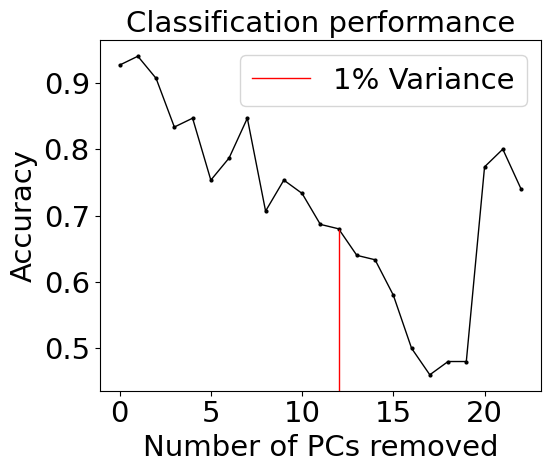

In [8]:
pc_low_variance = next(x[0] for x in enumerate(pca.explained_variance_ratio_) if x[1] < 0.01)
plt.plot([n for n in range(n_comp)],performance,'-o',linewidth=1,markersize=2,color='black')
plt.axvline(x=pc_low_variance, ymax=0.46,color='r', linestyle='-',linewidth=1,label='1% Variance')
plt.legend(fontsize=21)
plt.xlabel('Number of PCs removed',fontsize=21)
plt.ylabel('Accuracy',fontsize=21)
plt.title('Classification performance',fontsize=21)
plt.yticks(fontsize=21)
plt.xticks(fontsize=21)
plt.subplots_adjust(left=0.21,bottom=0.15)

### B. High-variance PCs : cross-projection similarity

1. Load the velocities and labels for each task (same as in section A.2.a)

In [ ]:
# Load the file from basecamp : 'synergies_tasks'
conds = pickle.load(open('/home/ingster/Bureau/SIL-BigResults/synergies_tasks','rb')) 

hold_velocities = np.concatenate([cond['hand velocity'] for cond in conds if cond['encoding']=='hold'])
cw_velocities = np.concatenate([cond['hand velocity'] for cond in conds if cond['encoding']=='cw'])
ccw_velocities = np.concatenate([cond['hand velocity'] for cond in conds if cond['encoding']=='ccw'])

n_comp = 23
n_highpc = 12 # Considering that the first 12 PCs account for most of the variance = high-variance PCs

2. a. Cross-projection \
b. Quantify the degree of similarity between subpaces by computing average V2/V1\
c. Visualize the degree of similarity between subspaces by plotting cumulative explained variances

In [ ]:
# Cross-projection
cproj_hold_cw = cross_project_kin(vel1=hold_velocities,vel2=ccw_velocities,n_comp=n_comp,n_highpc=n_highpc)
cproj_hold_ccw = cross_project_kin(vel1=hold_velocities,vel2=ccw_velocities,n_comp=n_comp,n_highpc=n_highpc)
cproj_ccw_cw = cross_project_kin(vel1=ccw_velocities,vel2=cw_velocities,n_comp=n_comp,n_highpc=n_highpc)

# Quantify
hold_cw = mean_ratio(n_highpc=n_highpc,cproj=cproj_hold_cw)
hold_ccw = mean_ratio(n_highpc=n_highpc,cproj=cproj_hold_ccw)
ccw_cw = mean_ratio(n_highpc=n_highpc,cproj=cproj_ccw_cw)

hold_cw_r = hold_cw[0]
hold_ccw_r = hold_ccw[0]
ccw_cw_r = ccw_cw[0]

V = {'hold vs. cw':np.round(hold_cw_r,7), 'hold vs. ccw':np.round(hold_ccw_r,7), 'cw vs. ccw':np.round(ccw_cw_r,7)}
print(V)

# Visualize
plot_cross_projection(n_comp=n_comp,cum_1_2=hold_cw[1],cum_2_1=hold_cw[2],label1='Hold on CW',label2='CW on hold')
plot_cross_projection(n_comp=n_comp,cum_1_2=hold_ccw[1],cum_2_1=hold_ccw[2],label1='Hold on CCW',label2='CCW on hold')
plot_cross_projection(n_comp=n_comp,cum_1_2=ccw_cw[1],cum_2_1=ccw_cw[2],label1='CCW on CW',label2='CW on CCW')
